In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
%pip install numpy pandas seaborn matplotlib scikit-learn xgboost hyperopt

In [2]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from xgboost import XGBClassifier
from hyperopt import fmin, hp, tpe, STATUS_OK

from src.util import evaluate_model, seed_everything, get_data

# import tensorflow as tf
# from tensorflow import keras
# from keras.utils import to_categorical

seed = 42
seed_everything(seed)

## Data inspection & selection
Load the dataset and look inside it

In [4]:
data = pd.read_parquet("data/job_table.parquet")
data.head(10)

: 

In [5]:
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}")
print(data.columns)

Number of rows: 6236346
Number of columns: 100
Index(['pn_min_cpus', 'resize_time', 'ntasks_per_socket', 'tres_freq',
       'comment', 'ntasks_per_socket_str', 'std_in', 'array_task_throttle',
       'max_nodes', 'contiguous', 'max_cpus', 'resv_name', 'user_id',
       'tres_per_task', 'derived_ec', 'tres_per_socket', 'exc_nodes',
       'tres_req_str', 'array_job_id', 'boards_per_node', 'priority',
       'num_nodes', 'tres_per_node', 'cpus_alloc_layout', 'name',
       'run_time_str', 'array_task_str', 'time_min', 'time_limit_str',
       'end_time', 'year_month', 'alloc_sid', 'mem_per_cpu', 'req_switch',
       'show_flags', 'group_id', 'wait4switch', 'array_task_id', 'exit_code',
       'mem_per_node', 'restart_cnt', 'requeue', 'tres_bind', 'profile',
       'batch_flag', 'plugin', 'work_dir', 'pn_min_memory', 'nice',
       'ntasks_per_node', 'ntasks_per_core_str', 'accrue_time',
       'tres_alloc_str', 'nodes', 'sockets_per_board', 'std_out',
       'array_max_tasks', 'job_id',

Since, the dataset contains a huge set of information, we decided to use only a smal subset of it. In particular, for the early stage of our work, we use submit time features. So, we have only data that have the string *tres_req_str* present (by which cpu,gpu,mem,ecc are rquested) and the toehr features avaliable at request time(requested by the submitter).

We only consider job that are in one of the possible states: COMPLETED, FAILED, OUT_OF_MEMORY, TIMEOUT

In [6]:
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "priority",
           "qos", "time_limit", "cpus_per_task", 'num_tasks', "tres_req_str", "job_state"]

# ["cpus_per_tres", "num_cpus", "num_nodes", "ntasks_per_socket", "req_nodes"]

df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016525,2020-10-08 20:31:23+00:00,32588,25200,sire_pjc,/m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...,m100_usr_prod,297707,normal,720,1,4,"cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1",COMPLETED
1016526,2020-10-09 05:18:51+00:00,31392,25200,praAnt-run4-2m,/m100_work/IscrB_INwARDS_0/NR/NR3/PRant-Run4/r...,m100_usr_prod,145536,normal,1440,32,4,"cpu=128,mem=237.50G,node=1,billing=128,gres/gpu=4",COMPLETED
1016527,2020-10-09 10:20:40+00:00,26429,25200,job_density.sh,/m100_scratch/userexternal/mfarnesi/CP2K_Inter...,m100_usr_prod,917,qos_lowprio,60,32,4,"cpu=128,mem=230000M,node=1,billing=128,gres/gpu=4",FAILED
1016528,2020-10-09 01:36:42+00:00,32232,25200,script.marconi100.x,/m100/home/userexternal/nthomopu/script.marcon...,m100_usr_prod,330946,normal,10,1,8,"cpu=8,mem=7100M,node=1,billing=8,gres/gpu=1",COMPLETED


Print number of  missing values per columns..

In [7]:
df = df.replace('', np.nan)
print(df.isna().sum())
prev_len = len(df)
print(f"Num of rows: {len(df)}")

submit_time          0
user_id              0
group_id             0
name                 0
command           3584
partition            0
priority             0
qos                  0
time_limit           0
cpus_per_task        0
num_tasks        37945
tres_req_str         0
job_state            0
dtype: int64
Num of rows: 1016530


The presence of nan values in thi subset is not too much. In order to avoid problem after, drop all the rows that contains at leat a nan values.

In [8]:
df = df.dropna().reset_index(drop=True)
print(df.isna().sum())
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len)):.1%})")

submit_time      0
user_id          0
group_id         0
name             0
command          0
partition        0
priority         0
qos              0
time_limit       0
cpus_per_task    0
num_tasks        0
tres_req_str     0
job_state        0
dtype: int64
Num of rows: 975170
Dropped rows: 41360 (4.1%)


Set time zone to None, bacuse we are not interested in it. At the end, store the subset for the future.

In [9]:
df["submit_time"] = df["submit_time"].dt.tz_localize(None)
df.to_pickle("data/job_table_reduced.pkl")
del data 
del df

## Data Preprocessing

In [3]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


As you can see from above table, not all the faetures are numeric, but there are a lot of text data. This type of date don't suit very well for learning algorithm, so fix it.

Start with those data types that are text, convert it into a number.

In [30]:
text_columns = ["name", "command", "partition", "qos"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in text_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Text columns transformed: {text_columns}")

df[df.columns[1:-2]] = df[df.columns[1:-2]].apply(pd.to_numeric)

display(df.head())
for col in text_columns:
    print(f"Number of unique values in {col} columns: {len(df[col].unique())}")

Text columns transformed: ['name', 'command', 'partition', 'qos']


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05,32171,25200,77949,62668,3,87034,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10,32171,25200,77949,62782,3,85884,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39,32171,25200,77949,62085,3,115982,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39,32152,25200,30918,51406,3,80216,4,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06,32171,25200,77949,62678,3,86934,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


Number of unique values in name columns: 78586
Number of unique values in command columns: 238768
Number of unique values in partition columns: 4
Number of unique values in qos columns: 8


Watching the above values, we can say that for **partition** and **qos** columns integer encodig is perfect due their few unique values. For the other 2 instead, it may be the case to find a better way in the feature to improve performance.

Now, for the **tres_req_str** we decide to split this column into 5 different columns: **req_cpu**, **req_mem**, **req_node**, **req_billing**, **req_gpu**. Each column is been filled with the value after the "=" and if not present with a 0. An example of string is and the corresponding splittig is:<br>
cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1
| req_cpu | req_mem | req_node | req_billing | req_gpu |
|---------|---------|----------|-------------|---------|
| 256     | 230000  | 1        | 256         | 1       |

In [31]:
labels = df.pop("job_state")

fields = ["req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]
req_str = df.pop('tres_req_str')
df[fields] = req_str.str.split(',', n=5, expand=True)
for f in fields:
    df[f] = df[f].apply(lambda c: re.sub("[a-zA-Z=/]", "", c) if c is not None else 0)
    
df[fields] = df[fields].apply(pd.to_numeric)   
    
df["job_state"] = labels.astype(str)

df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,2020-05-22 01:06:05,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,2020-05-22 01:06:10,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,2020-05-22 01:05:39,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,2020-05-22 18:56:39,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,2020-05-22 01:06:06,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Last column to preprocess is *submit_time*. For this column, we will use the proleptic Gregorian ordinal, so the count from the the day 1 of the month 1 of th year 1.

In [32]:
df["submit_time"] = df["submit_time"].apply(lambda c: c.toordinal())
df.head(5)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,737567,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Save the data for the future.

In [33]:
df.to_pickle("data/job_table_preproc.pkl")
del df

## Data Anlaysis

In [4]:
df = pd.read_pickle("data/job_table_preproc.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,737567,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000.0,1,4,0,COMPLETED
1,737567,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000.0,1,4,0,COMPLETED
2,737567,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000.0,1,4,0,COMPLETED
3,737567,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000.0,1,256,1,FAILED
4,737567,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000.0,1,4,0,COMPLETED


Print some statistics...

In [13]:
feature_to_describe = ["qos", "time_limit", "cpus_per_task", "num_tasks",
                        "req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]

df[feature_to_describe].describe().T

,count,mean,std,min,25%,50%,75%,max
qos,975170.0,3.983316,0.373767,0.0,4.0,4.0,4.0,7.0
time_limit,975170.0,1063.603737,511.217883,1.0,720.0,1440.0,1440.0,1440.0
cpus_per_task,975170.0,13.301554,16.250140,1.0,1.0,2.0,32.0,4444.0
num_tasks,975170.0,16.523853,160.926988,0.0,4.0,4.0,24.0,32768.0
req_cpu,975170.0,114.862959,621.956853,1.0,4.0,24.0,128.0,65536.0
req_mem,975170.0,98244.121300,534760.600495,1.0,237.5,8000.0,86000.0,57960000.0
req_node,975170.0,1.724648,7.200674,1.0,1.0,1.0,1.0,256.0
req_billing,975170.0,114.862959,621.956853,1.0,4.0,24.0,128.0,65536.0
req_gpu,975170.0,4.596272,27.519665,0.0,0.0,1.0,4.0,1024.0


From the above statistics, we can highlight:
1. data are neither normalized nor standardized
2. *qos* column have values very close to the mean, looking the std
3. half of the job have the maximum time limit
4. all the req features have values very smaller rather than the max, it mean that bigger values are outliers

Now, plot job's exit state statistics
<a id='job_state_dist'></a>

job_state
COMPLETED        0.879829
FAILED           0.101628
TIMEOUT          0.014265
OUT_OF_MEMORY    0.004277
Name: proportion, dtype: float64


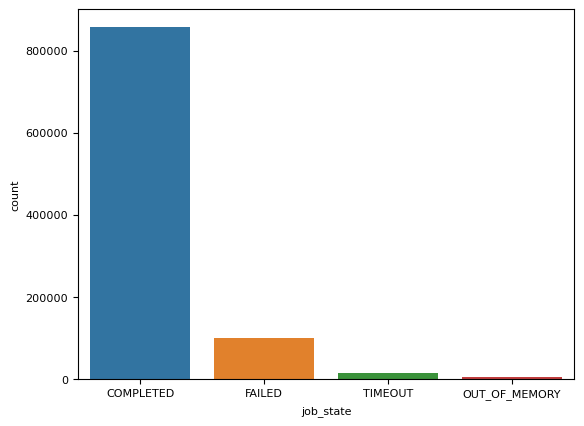

In [8]:
sns.countplot(x=df["job_state"])
print(df.job_state.value_counts(normalize=True))

As you can see, it is a very unbulanced dataset, but we expected it since we are work on HPC job and the presence of many failed would represent a big problem for the company.

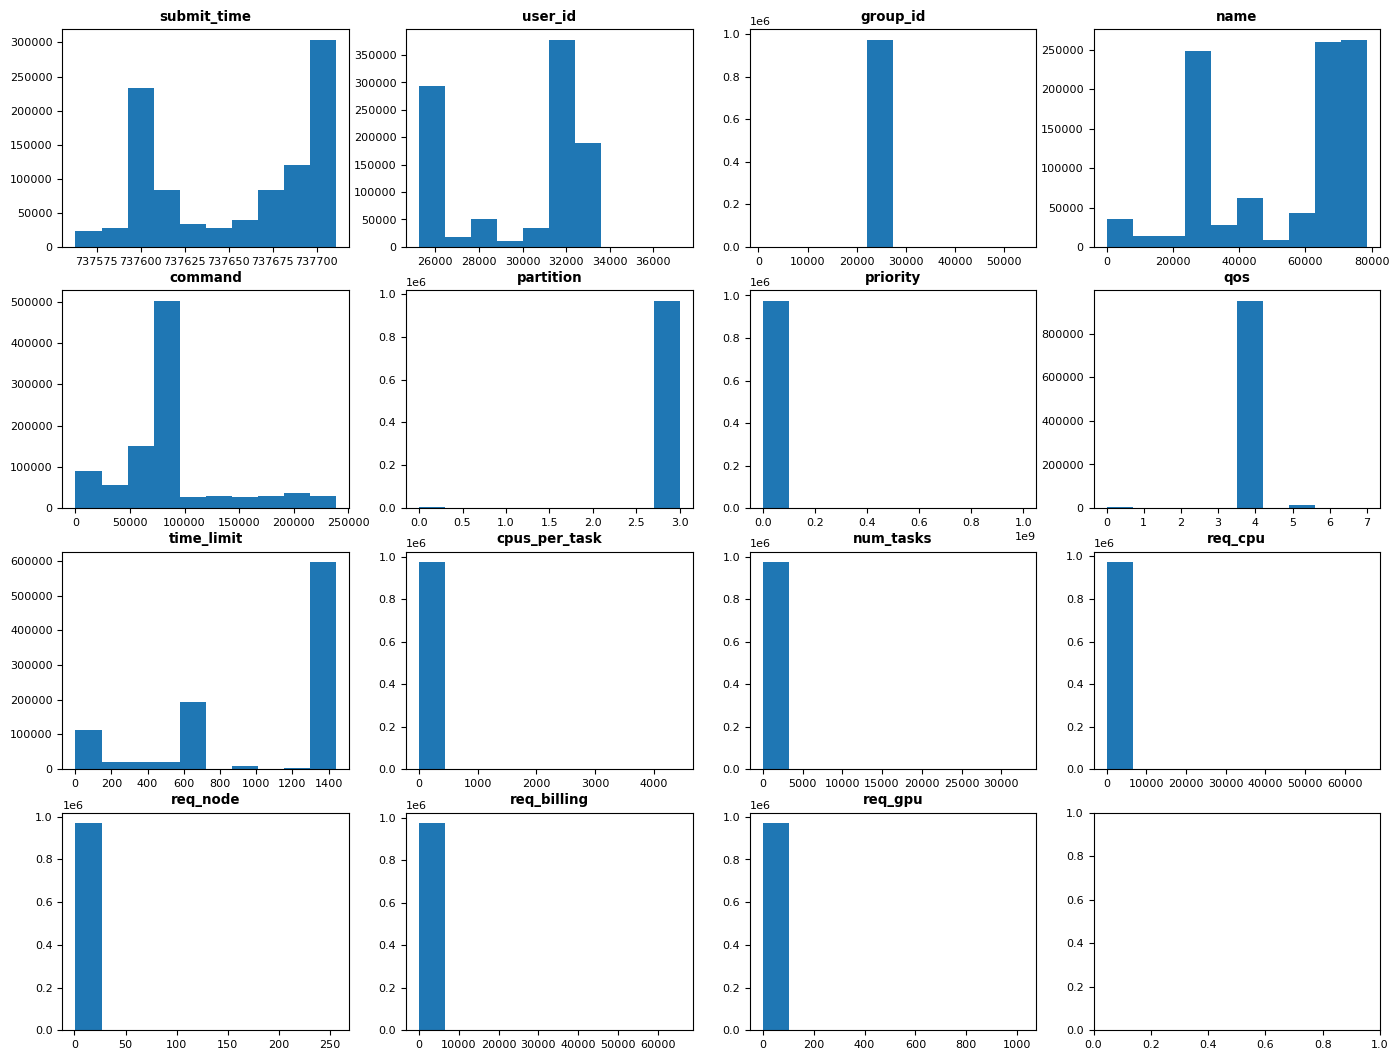

In [18]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(17, 13))
i, j = 0, 0
for col in cols:
    counts, edges, bars = axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1

<Axes: >

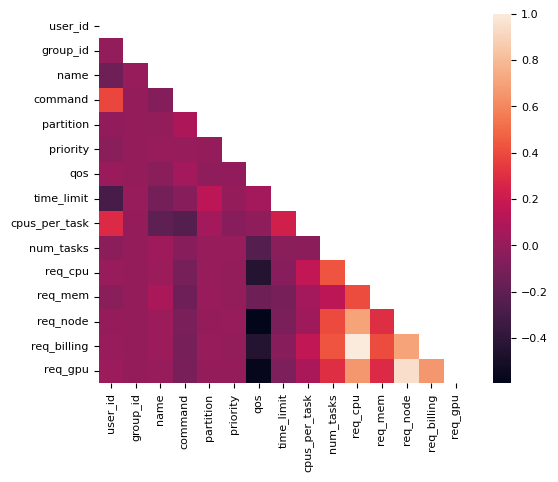

In [43]:
df_corr = df.drop(["job_state", "submit_time"], axis=1)
corr_matrix=df_corr.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, mask=mask, square=True)

Inspect unique column values to better understand how it's usefull for exit status detection. Now we only consider binary case for semplicity were job are or Completed or Failed

In [44]:
df_bin = df.drop(["submit_time"], axis=1)
df_bin["job_state"] = df_bin["job_state"].replace({"OUT_OF_MEMORY": "FAILED", "TIMEOUT": "FAILED"})
df_bin["job_state"] = df_bin["job_state"].replace({"COMPLETED": 0, "FAILED": 1}).astype(np.int64)

for col in df_bin.select_dtypes(include="int").columns:
    print(f"{col} unique values: {len(df_bin[col].unique())}")

user_id unique values: 510
group_id unique values: 6
name unique values: 78586
command unique values: 238768
partition unique values: 4
priority unique values: 86357
qos unique values: 8
time_limit unique values: 355
cpus_per_task unique values: 34
num_tasks unique values: 115
req_cpu unique values: 156
req_node unique values: 62
req_billing unique values: 156
req_gpu unique values: 71
job_state unique values: 2


Now excluding *command* feature which has to much unique values, plot hist plot

In [45]:
print_col = set(df_bin.columns).difference(set(["command", "job_state", "name", "priority"]))
fig, axs = plt.subplots(3, 4, figsize=(15, 15))

sns.histplot(data=df_bin, x="user_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_bin, x="group_id", hue="job_state", kde=True, color="skyblue", ax=axs[0, 1])
sns.histplot(data=df_bin, x="partition", hue="job_state", kde=True, color="skyblue", ax=axs[0, 2])
sns.histplot(data=df_bin, x="cpus_per_task", hue="job_state", kde=True, color="skyblue", ax=axs[0, 3])
sns.histplot(data=df_bin, x="num_tasks", hue="job_state", kde=True, color="skyblue", ax=axs[1, 0])
sns.histplot(data=df_bin, x="qos", hue="job_state", kde=True, color="skyblue", ax=axs[1, 1])
sns.histplot(data=df_bin, x="time_limit", hue="job_state", kde=True, color="skyblue", ax=axs[1, 2])
sns.histplot(data=df_bin, x="req_cpu", hue="job_state", kde=True, color="skyblue", ax=axs[1, 3])
sns.histplot(data=df_bin, x="req_mem", hue="job_state", kde=True, color="skyblue", ax=axs[2, 0])
sns.histplot(data=df_bin, x="req_node", hue="job_state", kde=True, color="skyblue", ax=axs[2, 1])
sns.histplot(data=df_bin, x="req_billing", hue="job_state", kde=True, color="skyblue", ax=axs[2, 2])
sns.histplot(data=df_bin, x="req_gres/gpu", hue="job_state", kde=True, color="skyblue", ax=axs[2, 3])

# i, j = 0, 0
# for col in print_col:
#     sns.histplot(data=df_bin, x=col, hue="job_state", kde=True, color="skyblue", ax=axs[i, j])
#     j+=1
#     if j%4 == 0:
#         i+=1
#         j=0

KeyboardInterrupt: 

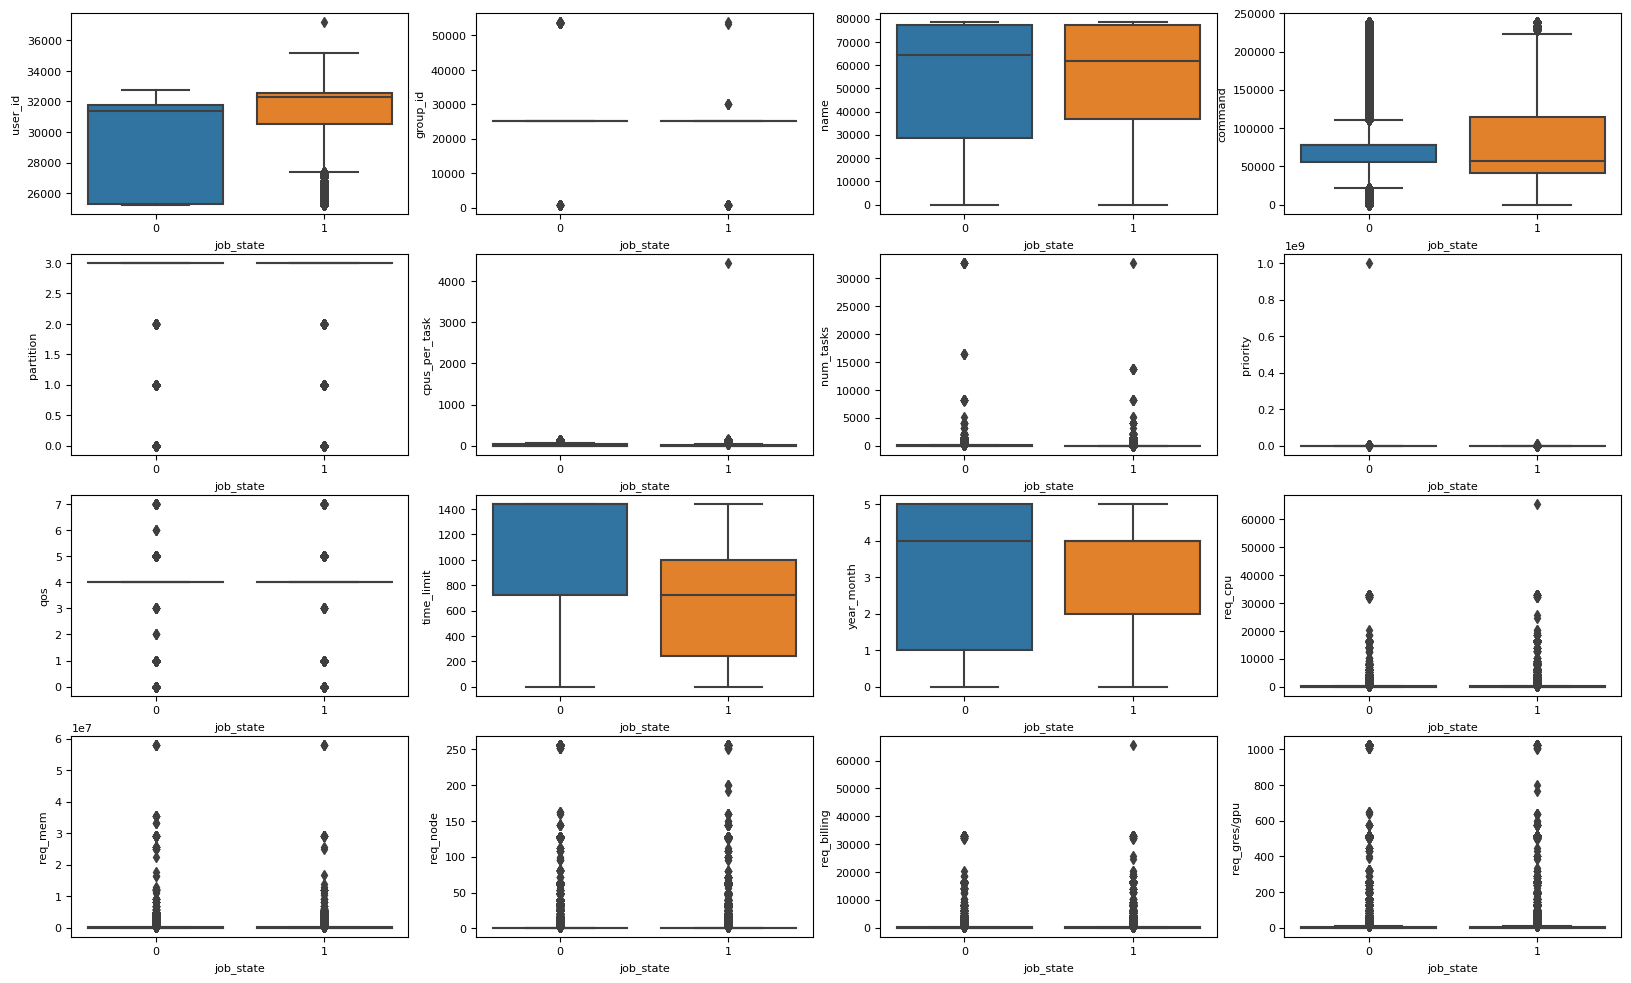

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

i, j = 0, 0
for col in df_bin.columns:
    if col != "job_state":
        sns.boxplot(x=df_bin["job_state"], y=df_bin[col], ax=axs[i, j])
        j+=1
        if j%4 == 0:
            i+=1
            j=0

# Job Exit State prediction - Binary

As first attempt we want identify only whether a job is completed or not. We firstly binirize our data, converting 'OUT_OF_MEMORY' and 'TIMEOUT' job states into 'FAILED'. Secondly, we assign to each job integer label in the following way:
 - **0**: for completed job
 - **1**: for those failed


In [32]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print()
print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(labels)))

Loading data... Lodaded!

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
New labels:  ['COMPLETED', 'FAILED']


Encode labels with integer values

In [33]:
lab_enc = {"COMPLETED": 0, "FAILED": 1}

print(f"Old values: {labels[:5]}")
labels = np.asarray([lab_enc[l] for l in labels])
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0 0 0 1 0]


Split the data into train, validation and test sets and normalize using only train information

In [34]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


Because of the high imbalance in the dataset, we weight each class with the invere of the class frequence. 
\begin{equation}
w = 
\begin{cases}
    \frac{1}{f_0} & \text{if }~~ y = 0 \\
    \frac{1}{f_1} & \text{otherwise.}
\end{cases}
\end{equation}

In [45]:
n_positives = sum(y_train)
total = len(y_train)

class_weight = {
    0: 1 / ((total-n_positives) / total),
    1: 1 / (n_positives / total)
}
class_weight

{0: 1.1370606889055925, 1: 8.29603803968037}

## Logistic Regression
Since we are working on a binary classification task, we started our model selection from the **Logistic Regression**. 

F1:
 - train set:		0.401
 - validation set:	0.400
Recall:
 - train set:		0.760
 - validation set:	0.758
Precision:
 - train set:		0.272
 - validation set:	0.272


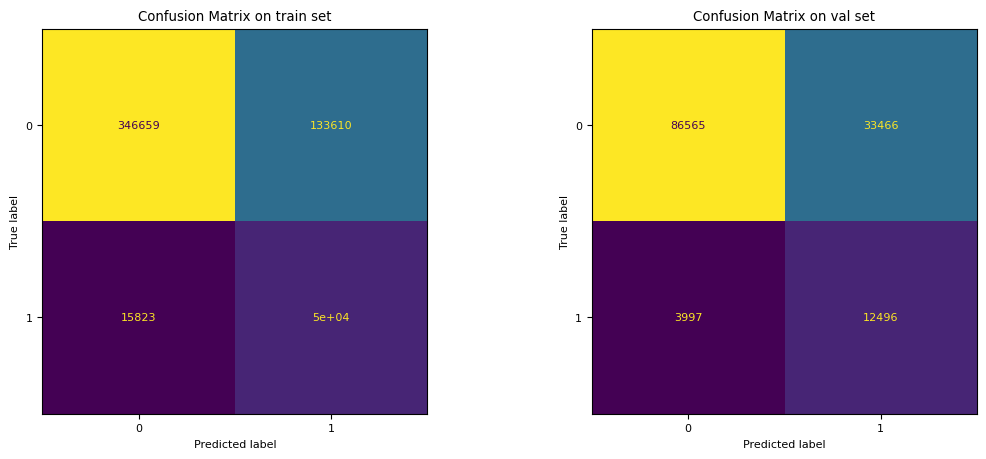

In [42]:
reg = LogisticRegression(class_weight=class_weight, random_state = seed, n_jobs=-1, max_iter=200)
reg.fit(x_train, y_train)
evaluate_model(reg)

Very poor performance. The regressor have the same performance on train and validation. The only interesting results is the Recall. Even though, the regressor is not capable to learn any usefull information from the data (F1 score worst than a random classifier), it's still capable enough to classify well whether a job is failed (the recall is over 75%). However, we decided to not tune this model and move on the next.

## Classification

### Decision Tree
One of the simplest classification algorithms is **Decision Tree**, let's test it and look how it performs.

F1:
 - train set:		0.975
 - validation set:	0.838
Recall:
 - train set:		0.999
 - validation set:	0.855
Precision:
 - train set:		0.924
 - validation set:	0.802


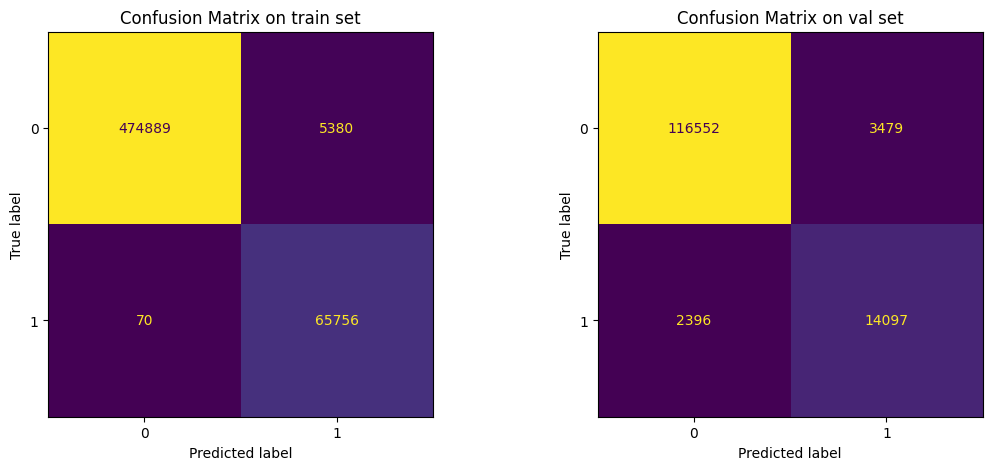

In [47]:
dt_bin = DecisionTreeClassifier(class_weight=class_weight, random_state = seed)
dt_bin = dt_bin.fit(x_train, y_train)
evaluate_model(dt_bin, x_train, x_val, y_train, y_val, average="binary")

Preatty good results on validation set. However, there is a big gap between the train and validation results. Indeed, the classifier lost around 14% on the second set. This results highlighted that the tends to classify a job as failed when uncertain. As yoi can notice, the number of false positive are triplicated on validation set, while the number of false negative remained costant.

Now, tune the DT-hyperparameters and try to improve results. We use a random serach over all the possible parameters configuration trying to increase both the F1 and the Recall. In this case the second is very important because minimizing the false negative bring more reliable system.

In [68]:
def rf_objective(search_space):
    model = DecisionTreeClassifier(class_weight=class_weight, random_state = seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.5, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

dt_search_space={'n_estimators':hp.randint('n_estimators',200,1000),
                 'max_depth': hp.randint('max_depth',10,200),           
                 'min_samples_split':hp.uniform('min_samples_split',0,1),   
                 'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
                 'max_features':hp.choice('max_features',['sqrt', 'log2']) 
}

dt_best_params = fmin(
  fn=rf_objective,
  space=dt_search_space,
  algo=tpe.suggest,
  max_evals=200)

print("Best param Decision Tree (binary):")
print(dt_best_params)

Best params:
{'min_samples_leaf': 1}
F1:
 - train set:		0.960
 - validation set:	0.828
Recall:
 - train set:		0.999
 - validation set:	0.855
Precision:
 - train set:		0.924
 - validation set:	0.802


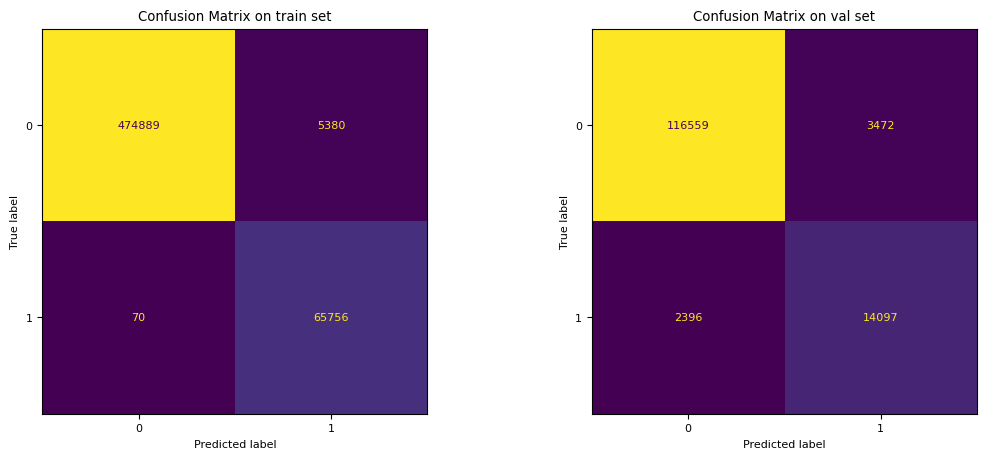

In [69]:
dt_bin_tuned = DecisionTreeClassifier(class_weight=class_weight, random_state=seed, **dt_best_params)
dt_bin_tuned.fit(x_train, y_train)
evaluate_model(dt_bin_tuned)

Gain somthing, but nothing expecial

### Ensemble algorithm
In the field of machine learning, **ensemble methods** are used to combine base estimators (i.e. weak learners). Two types of ensemble methods are averaging (eg. bagging) and boosting (eg. gradient boosting). Ensemble methods not only increase the performance but also reduce the risk of overfitting. We start using the bagging one, expecially the **Random Forest**.

It consists of a large number of individual Decision Trees, where at the end the predictions of the learners are aggregated. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

In [2]:
rf_bin = RandomForestClassifier(class_weight=class_weight, random_state=seed)
rf_bin.fit(x_train, y_train)
evaluate_model(rf_bin, x_train, x_val, y_train, y_val)

NameError: name 'RandomForestClassifier' is not defined

As always, tune the model

In [10]:
def rf_objective(search_space):
    model = RandomForestClassifier(class_weight=class_weight, random_state=seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

rf_search_space={'n_estimators':hp.randint('n_estimators',100,1000),
                 'max_depth': hp.randint('max_depth',10,200),           
                 'min_samples_split':hp.uniform('min_samples_split',0,1),   
                 'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
                 'max_features':hp.choice('max_features',['sqrt', 'log2']) 
}

rf_best_params = fmin(
  fn=rf_objective,
  space=rf_search_space,
  algo=tpe.suggest,
  max_evals=200)

print("Best param Random Forest (binary):")
print(rf_best_params)

In [3]:
rf_bin_tuned = RandomForestClassifier(class_weight=class_weight, random_state=seed, **rf_best_params)
rf_bin_tuned.fit(x_train, y_train)
evaluate_model(rf_bin_tuned)

NameError: name 'RandomForestClassifier' is not defined

As you can see, tuning the model we lost a bit of F1 score, but we have greatly increased the Recall over the 90% on the validations set. With the Random Forest we obtain slightly better results compared to those obtained so far. This means that the powerness of use multiple Decision Tree togheter and aggregate the results help the classifier to better abstract the data. 

The last algorithm class tested is the **Gradient Booosting**. In particulare we use the **XGBoost**, that is a open-source implementation of the gradient boosted trees algorithm. It is so called for the uses of Decision Trees as weak classifiers and the gradient descent as loss function optimizer.

F1:
 - train set:		0.721
 - validation set:	0.715
Recall:
 - train set:		0.969
 - validation set:	0.961
Precision:
 - train set:		0.574
 - validation set:	0.569


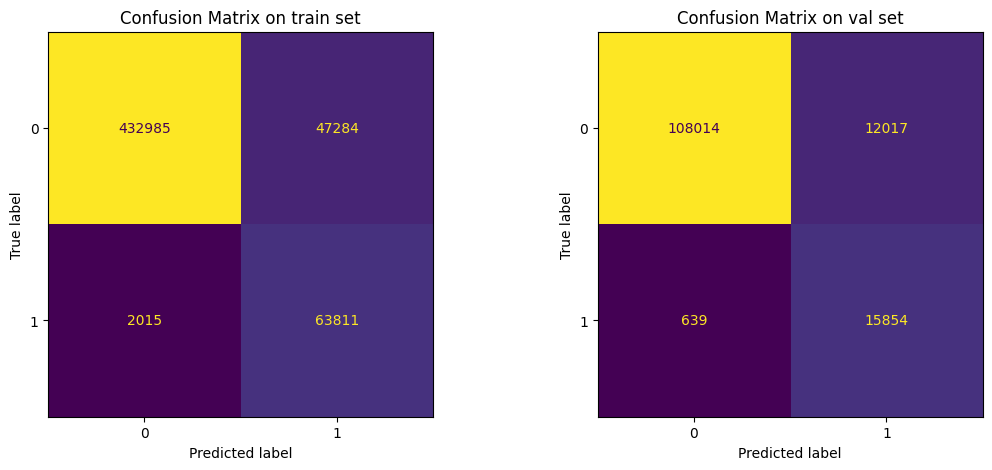

In [7]:
xgb_clf = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        scale_pos_weight=(total - n_positives) / n_positives,
                        random_state=seed,
                        n_jobs = -1,
)
xgb_clf.fit(x_train, y_train)
evaluate_model(xgb_clf, x_train, x_val, y_train, y_val)

In [ ]:
def xgb_objective(search_space):
    model = XGBClassifier(objective='binary:logistic',
                         booster='gbtree',
                         scale_pos_weight=(total - n_positives) / n_positives,
                         random_state=seed,
                         n_jobs = -1,
                         **search_space
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

xgb_search_space={'n_estimators':hp.randint('n_estimators',200,1000),
                 'max_depth': hp.randint('max_depth',1,10),           
                 'eta':hp.uniform('eta',0.01,0.2),   
                 'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
                 'max_features':hp.choice('max_features',['sqrt', 'log2']) 
}

# Job Exit State prediction - Multiclass
Once completed the binary task, we extend it to the multiclass one. Indeed, inside the dataset failed job could in three status:
1. **FAILED**: the job contains an error end it fails
2. **OUT OF MEMORY**: the job exceed its memory limit and it has been terminated
3. **TIMEOUT**: as for the previus, terminated beacuse exeeded the time limit



In [3]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print("Labels:", np.unique(labels))

Loading data... Lodaded!
Labels: ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']


In [4]:
lab_enc_mc = LabelEncoder()
print(f"Old values: {labels[:5]}")
labels = lab_enc_mc.fit_transform(labels)
print(f"Old values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
Old values: [0 0 0 1 0]


Split the data into train, validation and test sets and normalize using only train information

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


As mentioned in this [plot]{#job_state_dist} in data analisys, data are heavly unbalanced. Let's assign to each class a weight proportional to the inverse of its frequence in the train split

In [6]:
total = len(y_train)
lbl_freq = np.bincount(y_train)
class_weight_mc = {k:1/(freq/total) for k,freq in enumerate(lbl_freq)}
class_weight_mc

{0: 1.1370606889055925,
 1: 9.808445290609958,
 2: 232.67788666382614,
 3: 69.98526207868768}

## Decision Tree
As before, start with the easiest classifier and use the trees to infer knowledge on our data.

F1:
 - train set:		0.954
 - validation set:	0.784
Recall:
 - train set:		0.989
 - validation set:	0.804
Precision:
 - train set:		0.891
 - validation set:	0.748


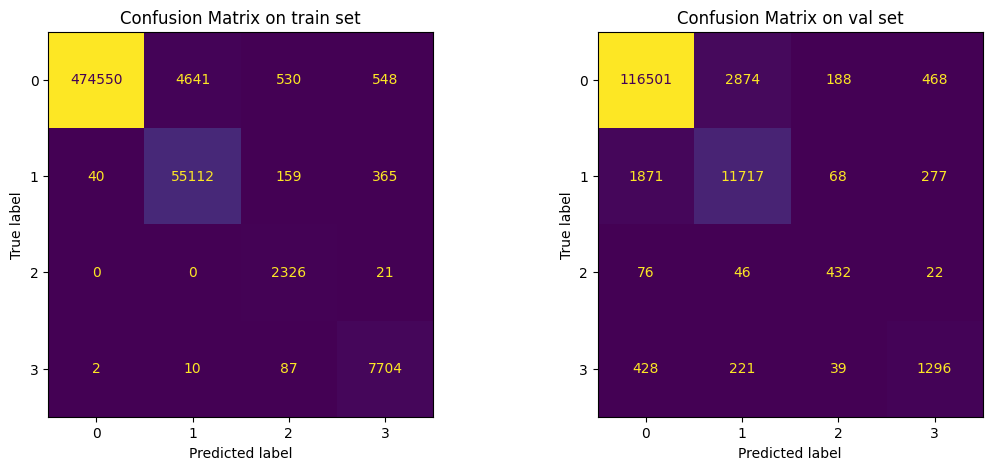

In [19]:
dt_clf_mc = DecisionTreeClassifier(class_weight=class_weight_mc, random_state = seed)
dt_clf_mc = dt_clf_mc.fit(x_train, y_train)
evaluate_model(dt_clf_mc, x_train, x_val, y_train, y_val, average="macro")

This results are still encouraging. Indeed, with basic setup we saw a quiet good score in terms of F1 and Recall on validation set. The big gap between train and validation performance highlights the overfitting. This means that hyperparameters such as reducing the depth of the trees help the classifier to better abstract the data. All in all, we lost less than 10% point from the binary case, so we are satisfied with the results.

Now, let's tune some parameters to increase the perfomance.

In [ ]:
def dt_mc_objective(search_space):
    model = DecisionTreeClassifier(class_weight=class_weight, random_state = seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

dt__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

dt_mc_best_params = fmin(
  fn=dt_mc_objective,
  space=dt__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for Decision Tree (multiclass):")
print(dt_mc_best_params)

In [ ]:
dt_clf_mc_tuned = DecisionTreeClassifier(class_weight=class_weight, random_state = seed, **dt_mc_best_params)
dt_clf_mc_tuned = dt_clf_mc_tuned.fit(x_train, y_train)
evaluate_model(dt_clf_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

## Ensamble Classifier

F1:
 - train set:		0.957
 - validation set:	0.795
Recall:
 - train set:		0.988
 - validation set:	0.806
Precision:
 - train set:		0.900
 - validation set:	0.775


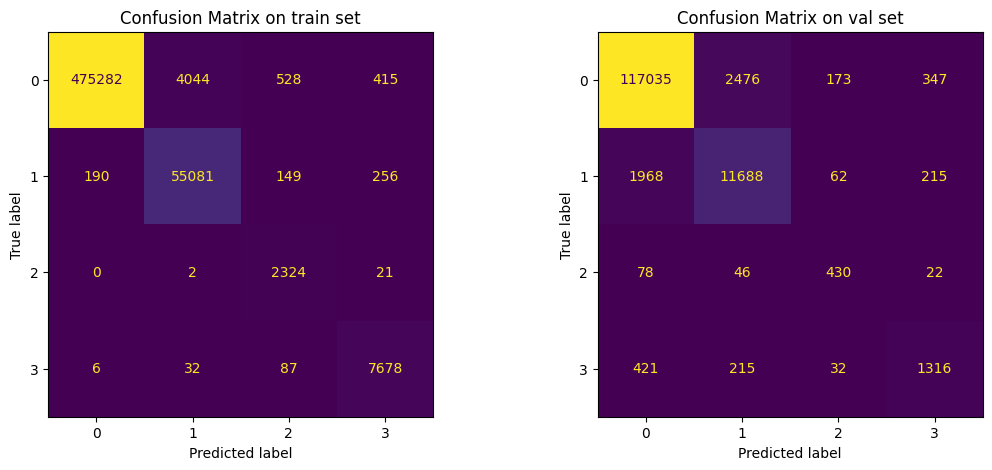

In [17]:
rf_mc_clf = RandomForestClassifier(class_weight=class_weight_mc, random_state=seed)
rf_mc_clf.fit(x_train, y_train)
evaluate_model(rf_mc_clf, x_train, x_val, y_train, y_val, average="macro")

There results are very much in line with those of the Decision Tree. Tune it in order to increase the performance a bit.

In [ ]:
def rf_mc_objective(search_space):
    model = RandomForestClassifier(class_weight=class_weight_mc, random_state=seed, **search_space)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.2, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

rf__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

rf_mc_best_params = fmin(
  fn=rf_mc_objective,
  space=rf__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for Random Forest (multiclass):")
print(rf_mc_best_params)

In [ ]:
rf_mc_tuned = RandomForestClassifier(class_weight=class_weight, random_state = seed, **rf_mc_best_params)
rf_mc_tuned = rf_mc_tuned.fit(x_train, y_train)
evaluate_model(rf_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

Comment on tuned results

And as did before, we try also the Gradient Boosting algorithm, in particulat **XGBoost**.

F1:
 - train set:		0.763
 - validation set:	0.741
Recall:
 - train set:		0.730
 - validation set:	0.709
Precision:
 - train set:		0.862
 - validation set:	0.840


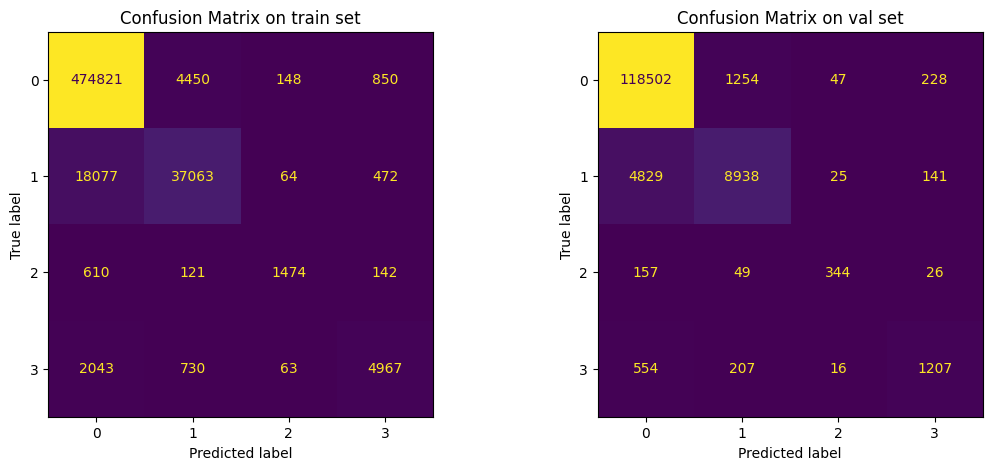

In [11]:
xgb_mc = XGBClassifier(objective='multi:softmax',
                        booster='gbtree',
                        random_state=seed,
                        n_jobs = -1,
)
xgb_mc.fit(x_train, y_train)
evaluate_model(xgb_mc, x_train, x_val, y_train, y_val, average="macro")

As always, tune the classifier

In [ ]:
def xgb_mc_objective(search_space):
    model = XGBClassifier(objective='multi:softmax',
                          booster='gbtree',
                          random_state=seed,
                          n_jobs = -1,
                          **search_space
    )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    f_beta = fbeta_score(y_val, y_pred, beta = 1.5, average="binary")
    return {'f_beta': -f_beta, 'status': STATUS_OK}

xgb__mc_search_space={'max_depth': hp.randint('max_depth',50,100),
                     'min_samples_split': hp.randint('min_samples_split',1,40),
                     'min_samples_leaf':hp.randint('min_samples_leaf',1,20),
                     'max_features':hp.choice('max_features',[None, 'sqrt', 'log2']) 
}

xgb_mc_best_params = fmin(
  fn=xgb_mc_objective,
  space=xgb__mc_search_space,
  algo=tpe.suggest,
  max_evals=100)

print("Best param for XGBoost (multiclass):")
print(xgb_mc_best_params)

In [ ]:
xgb_mc_tuned = XGBClassifier(objective='multi:softmax',
                             booster='gbtree',
                             random_state=seed,
                             n_jobs = -1,
                             **xgb_mc_best_params
)
xgb_mc_tuned = xgb_mc_tuned.fit(x_train, y_train)
evaluate_model(xgb_mc_tuned, x_train, x_val, y_train, y_val, average="macro")

## Ensemble of Ensembles

In [90]:
train_labels = []
for lbl in range(4):
    train_labels.append([int(y_train[i] == lbl) for i in range(len(y_train))])

In [121]:
classes_freq = [np.bincount(train_labels[i]) for i in range(4)]
weights = [{k:1/(freq/total) for k,freq in enumerate(classes_freq[i])} for i in range(4)]
weights

[{0: 8.29603803968037, 1: 1.1370606889055925},
 {0: 1.1135274122739942, 1: 9.808445290609958},
 {0: 1.004316337715265, 1: 232.67788666382614},
 {0: 1.0144958498361483, 1: 69.98526207868768}]

In [130]:
weights[0] = {0:1, 1:1}

[{0: 1, 1: 1},
 {0: 1.1135274122739942, 1: 9.808445290609958},
 {0: 1.004316337715265, 1: 232.67788666382614},
 {0: 1.0144958498361483, 1: 69.98526207868768}]

In [132]:
rf_bin_task = [DecisionTreeClassifier(class_weight=weights[i], random_state=seed) for i in range(4)]
for i in range(4):
    rf_bin_task[i].fit(x_train, train_labels[i])

In [135]:
preds = []
for i in range(4):
    pred = rf_bin_task[i].predict(x_val)
    preds.append(pred)
preds = np.asarray(preds).T

In [136]:
preds

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [134]:
final_pred = np.argmax(preds, axis=1)
prec, rec, f1, _ = precision_recall_fscore_support(y_val, final_pred, beta=1.5, average="macro")
print(f"F1:\t\t{f1:.3f}")
print(f"Recall:\t\t{rec:.3f}")
print(f"Precision:\t{prec:.3f}")

F1:		0.784
Recall:		0.785
Precision:	0.789


In [ ]:
F1:		0.783
Recall:		0.765
Precision:	0.831

# Using Neural Networks

Build the model

In [ ]:
def build_mlp_model(input_shape, output_shape, hiddens):
    model_in = keras.Input(shape=input_shape)
    x = model_in
    for h in hiddens:
        x = keras.layers.Dense(h, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    model_out = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(model_in, model_out)
    return model

In [ ]:
class WeightBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        weights_v = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss

In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)

model = build_mlp_model((None, x_train.shape[1], ), 1, hiddens=[256, 128, 256])
model.compile(loss=WeightBCE(weights),
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, 15)]        0         
                                                                 
 dense_22 (Dense)            (None, None, 256)         4096      
                                                                 
 dense_23 (Dense)            (None, None, 128)         32896     
                                                                 
 dense_24 (Dense)            (None, None, 256)         33024     
                                                                 
 dropout_6 (Dropout)         (None, None, 256)         0         
                                                                 
 dense_25 (Dense)            (None, None, 1)           257       
                                                                 
Total params: 70,273
Trainable params: 70,273
Non-trainable

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=256, callbacks=[])
# model.save_weights("checkpoints/mlp_wbce.h5")

Epoch 1/30


2023-06-05 12:20:08.665347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]
2023-06-05 12:20:08.665631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]


1690/1707 [============================>.] - ETA: 0s - loss: 0.4313 - accuracy: 0.7003

2023-06-05 12:20:15.059207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]
2023-06-05 12:20:15.059438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]


1707/1707 [==============================] - 7s 3ms/step - loss: 0.4309 - accuracy: 0.7006 - val_loss: 0.3791 - val_accuracy: 0.7119
Epoch 2/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3556 - accuracy: 0.7693 - val_loss: 0.3307 - val_accuracy: 0.7953
Epoch 3/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3243 - accuracy: 0.7973 - val_loss: 0.3155 - val_accuracy: 0.7957
Epoch 4/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3106 - accuracy: 0.8091 - val_loss: 0.3040 - val_accuracy: 0.8145
Epoch 5/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.3027 - accuracy: 0.8145 - val_loss: 0.3146 - val_accuracy: 0.8158
Epoch 6/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.2961 - accuracy: 0.8189 - val_loss: 0.2893 - val_accuracy: 0.8260
Epoch 7/30
1707/1707 [==============================] - 6s 3ms/step - loss: 0.2899 - accuracy: 0.8235 - val_loss: 0.2869 - val_accuracy: 0.8159
Epo

146/286 [==============>...............] - ETA: 0s

2023-06-05 12:30:20.853114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,15]
	 [[{{node Placeholder/_10}}]]
2023-06-05 12:30:20.853344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,15]
	 [[{{node Placeholder/_10}}]]


286/286 [==============================] - 0s 1ms/step
F1 on test set: 0.61
Recall on test set: 0.95
Precision on test set: 0.45



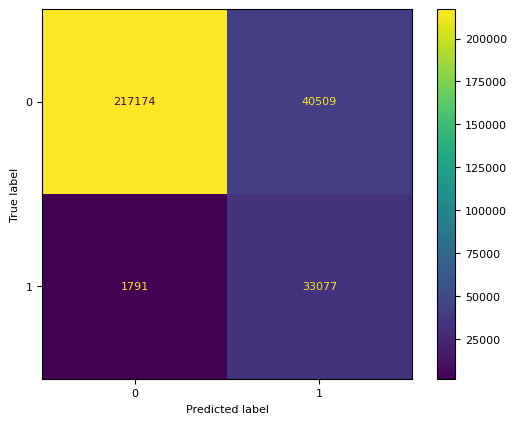

In [ ]:
# model.load_weights("checkpoints/tabMLP_wbce.h5")

y_pred = model.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1:.2f}")
print(f"Recall on test set: {recall:.2f}")
print(f"Precision on test set: {precision:.2f}")
print()

### Using Transformers

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          max_depth=6,
                          scale_pos_weight=0.7,
                          eval_metric="logloss",
                          seed=seed,
                          eta=0.1)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

F1 on test set: 0.6632287161287936


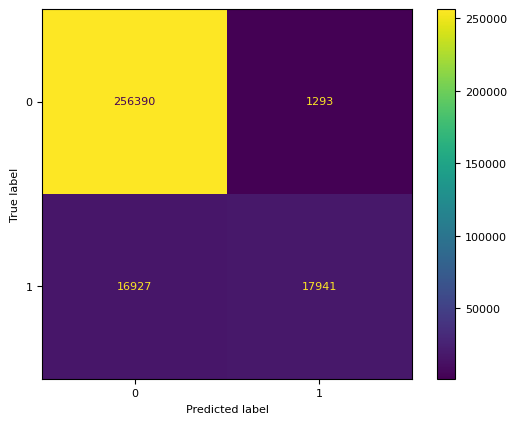

In [ ]:
y_pred = model.predict(x_test)
f1 = f1_score(y_test, y_pred)
print("F1 on test set:", f1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()